# Семинар 7. Бустинги

### 1. Бэггинг и бустинг: идеи подходов

Основная идея **бэггинга** состоит в том, чтобы агрегировать ответы большого числа независимых переобученных моделей, имеющих низкое смещение и большую дисперсию. Агрегация позволяет добиться значительного снижения дисперсии при сохранении низкого смещения. Бэггинг над деревьями, в котором при построении каждого дерева при разбиениях используются случайные подмножества признаков, называется **случайным лесом**.

Идея бустинга заключается в последовательном построении алгоритмов, каждый из которых учитывает ошибки построенной до сих пор композиции.

$$
    \sum_{i = 1}^{\ell}
        L(y_i, a_{N - 1}(x_i) + \gamma_N b_N(x_i))
    \to
    \min_{b_N, \gamma_N}
$$


**Вопросики:**
- Что происходит на шаге $0$?
- Что происходит на шаге $N$?

$$ s_i
    =
    -
    \left.
    \frac{\partial L(y_i, z)}{\partial z}
    \right|_{z = a_{N - 1}(x_i)}
$$

$$
b_N(x)
    =
    argmin
        \sum_{i = 1}^{l}
            \left(
                b(x_i) - s_i
            \right)^2
$$

#### 1.1 Простой пример. 

Пусть мы решаем задачу регрессии на тренировочной выборке $(X, y)$. Мы обучаем модель $a(X)$, которая является композицией базовых моделей $b_n(X)$. Будем считать, что композиция строится простым суммированием ответов базовых моделей:

$$
a(X) = \sum_{n = 1}^{k} b_n(X).
$$

В качестве базовой модели будем использовать решающее дерево глубины один (decision stump). 

Будем решать задачу при помощи минимизации среднеквадратичной ошибки:

$$
\dfrac{1}{\ell}\sum_{i = 1}^{\ell} (a(x_i) - y_i)^2 \to \min_a.
$$

В этом примере будем работать только с обучающей выборкой.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

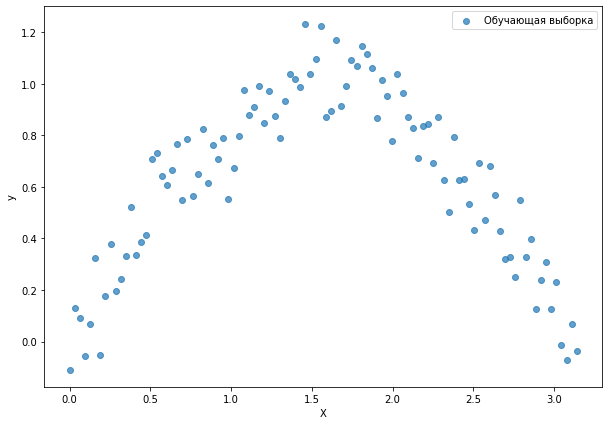

In [2]:
np.random.seed(123)
N = 100
X = np.linspace(0, 1*np.pi, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size = N)

# Функция для визуализации выборки и предсказаний
def plot_sample_model(X, y, plot_predictions=False, y_pred=None, y_pred_label=None, loss='mse'):
    plt.figure(figsize = (10, 7))
    plt.scatter(X, y, label = 'Обучающая выборка', alpha = 0.7)
    if plot_predictions:
        plt.plot(X, y_pred, label = y_pred_label, c = 'r')
        if loss == 'mse':
            plt.title('MSE: ' + str(mean_squared_error(y, y_pred)))
        elif loss == 'mae':
            plt.title('MAE: ' + str(mean_absolute_error(y, y_pred)))
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend();
    
plot_sample_model(X, y, plot_predictions = False)

**Шаг 0.** Имеем пустую композицию решающих деревьев $a(X) = \{\}$.

In [3]:
a = 0

**Шаг 1.** Обучим первое решающее дерево $DT_1$ и включим его в композицию: $a^{(1)}(X) = DT_1$. Получим предсказания композиции на обучающей выборке.

In [4]:
from sklearn.tree import DecisionTreeRegressor


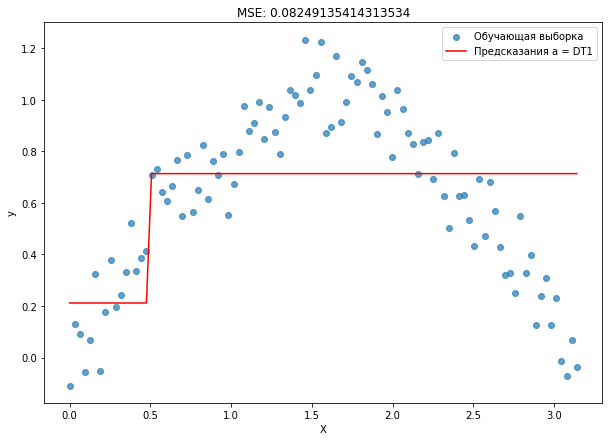

In [5]:
# TODO: обучите решающее дерево глубины 1 и сделайте предсказания на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# TODO: включите предсказания первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1')

**Шаг 2.** В качестве ошибок композиции будем использовать **сдвиги**, в случае MSE — это то же самое, что и остатки или ошибки


**Задание:** вычислите градиент $MSE$

$$
L(y, p) = \dfrac{1}{2} \sum_{i = 1}^{\ell} (y_i - p_i)^2
$$

по $p_i$ в точке $p_i = a(x_i)$.

**Решение:** 

$$
\dfrac{\partial L(y, p)}{\partial p_i} = -(y_i - p_i) = \{p_i = a(x_i)\} = -(y_i - a(x_i)).
$$

Таким образом, антиградиент функции потерь равен:

$$
s_i = - (-(y_i - a(x_i))) = y_i - a(x_i),
$$

In [6]:
# TODO: рассчитайте сдвиги  
s1 = y - a

**Шаг 3.** Обучим второе решающее дерево $DT_2$, предсказывающее сдвиги. Добавим предсказания второго дерева в композицию: $a^{(2)}(X) = DT_1 + DT_2$. Получим предсказания композиции на обучающей выборке.

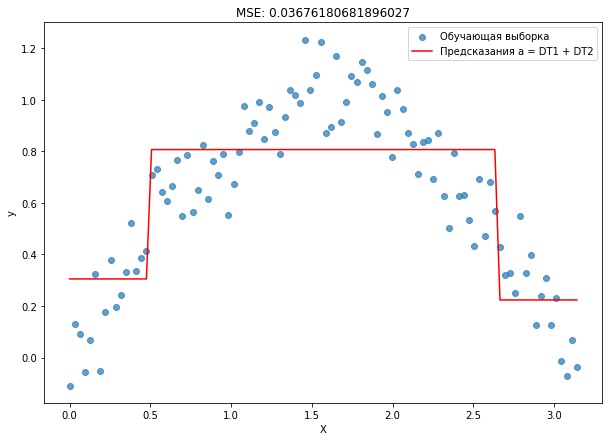

In [7]:
# TODO: обучите второе решающее дерево глубины 1, предсказывающее остатки
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# TODO: сделайте предсказания на обучающей выборке
dt2_pred = dt2.predict(X)

# TODO: включите предсказания второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1 + DT2')

Как мы видим, решающая поверхность стала более сложной, и теперь она более точно приближает обучающую выборку. 

**Шаги 4 – ...** Повторяем шаги 2-3, пока не надоест.

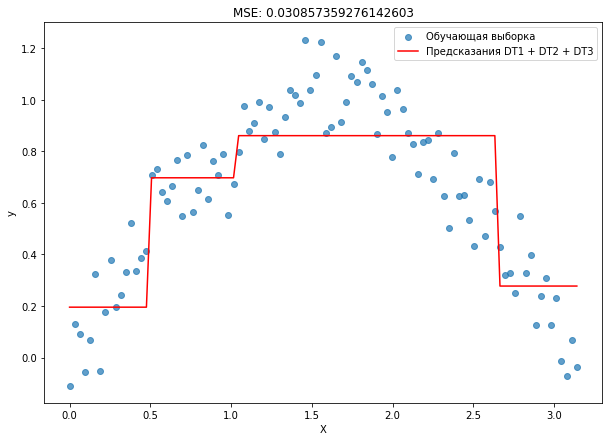

In [8]:
# TODO: рассчитайте остатки
s2 = y - a

# TODO: обучите третье решающее дерево глубины 1, предсказывающее остатки
dt3 = DecisionTreeRegressor(max_depth = 1)
dt3.fit(X, s2)

# TODO: сделайте предсказания на обучающей выборке
dt3_pred = dt3.predict(X)

# TODO: включите предсказания третьего дерева в композицию (простым суммированием)
a += dt3_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания DT1 + DT2 + DT3')

Как мы видим, при добавлении базовых моделей решающая поверхность становится более сложной и всё точнее приближает обучающую выборку.

**Важный момент:** заметим, что при обучении очередной базовой модели композиция предыдущего шага считается фиксированной. Это означает, что обучение новой базовой модели не влияет на уже обученные модели, содержащиеся в композиции.

### 2. Функции потерь градиентного бустинга для регрессии и классификации

#### 2.1 Регрессия.

В задачах регрессии в качестве целевой функции для композиции обычно берутся:

1. $MSE$, которую мы рассматривали ранее.

2. $MAE$:

$$
MAE(y, p) = \sum_{i = 1}^{\ell} |y_i - p_i|
$$

Попробуем сделать шаг градиентного бустинга, используя в качестве функции потерь $MAE$.

**Задание:** рассчитайте $s_i$ для $MAE$.

**Решение:** $s_i^{(N)} = -\mathrm{sign}(a^{(N-1)}(x_i) - y_i)$.

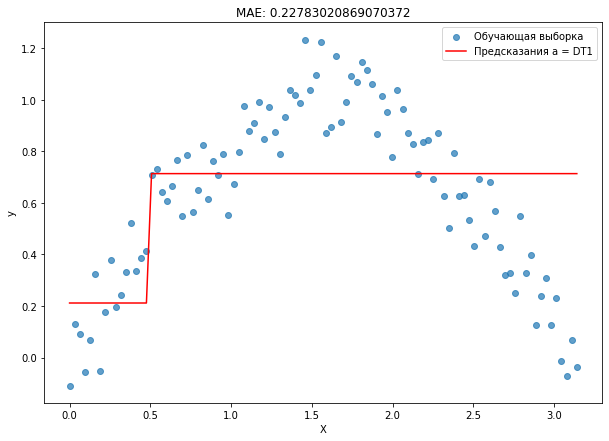

In [9]:
# Инициализация
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1', loss = 'mae')

In [10]:
# TODO: рассчитайте антиградиент  
s1 = -np.sign(a - y)

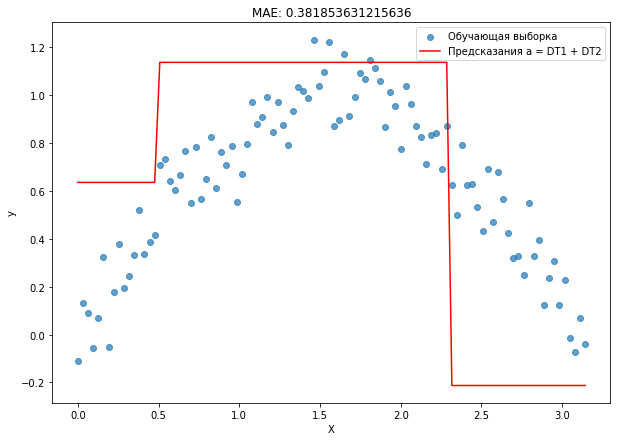

In [11]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, 
                  y_pred_label = 'Предсказания a = DT1 + DT2', loss = 'mae')

Заметим, что $MAE$ увеличилась, а решающая поверхность имеет "виток", уходящий за пределы обучающей выборки. Эту проблему мы решим позже.

#### 2.2 Классификация.

В задачах бинарной классификации обычно используется логистическая функция потерь, с которой мы уже сталкивались в логистической регрессии.

$$
L(y, p) = \log(1 + e^{-yp}).
$$

Плиз, умейте показывать, что в этом случае антиградиенты можно вычислить по формуле

$$
s^{(N)}_i = \dfrac{y_i}{1 + e^{y_ia^{(N-1)}(x_i)}}
$$

Попробуем сделать шаг градиентного бустинга в задаче бинарной классификации с логистической функцией потерь.

In [12]:
from sklearn.datasets import make_moons, load_iris # import function from the library

N = 1000

X, y = make_moons(n_samples=N, noise=0.1, random_state=11) # generate data sample
y = y * 2 - 1 # {-1, +1}

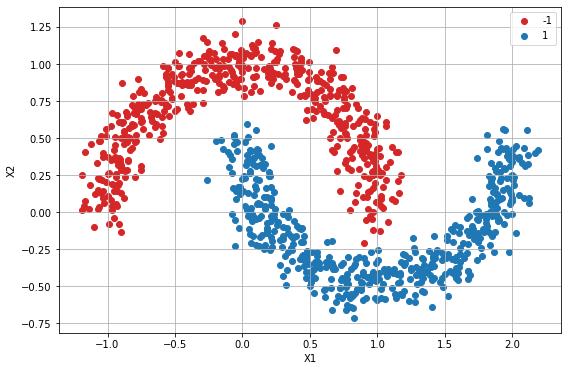

In [13]:
# Create an figure with a custom size
plt.figure(figsize=(9, 6))

# Plot all objects with y == 0 (class 0)
plt.scatter(X[y == -1, 0],     # selects all objects with y == 0 and the 1st column of X
            X[y == -1, 1],     # selects all objects with y == 0 and the 2nd column of X
            color='C3',        # points color
            label='-1')        # label for the plot legend


# Plot all objects with y == 1 (class 1)
plt.scatter(X[y == 1, 0],     # selects all objects with y == 1 and the 1st column of X
            X[y == 1, 1],     # selects all objects with y == 1 and the 2nd column of X
            color='C0',        # points color
            label='1')        # label for the plot legend

plt.xlabel('X1') # set up X-axis label
plt.ylabel('X2') # set up Y-axis label

plt.legend(loc='best') # create the plot legend and set up it position
plt.grid() # create grid on the plot

plt.show() # display the plot


In [14]:
# Инициализация
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

In [15]:
def log_loss(y, y_pred):
    return np.log(1 + np.exp(- y * y_pred)).mean()

In [16]:
from sklearn.metrics import roc_auc_score

# Вычисление ошибки для одного дерева
ll = log_loss(y, a)
print("LogLoss = %f" % (ll))

# Вычисление ROC AUC
auc = roc_auc_score(y, a)
print("ROC AUC = %f" % (auc))

LogLoss = 0.507347
ROC AUC = 0.839000


In [17]:
# TODO: рассчитайте антиградиент  
s1 = y / (1 + np.exp(y*a))

In [18]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += dt2_pred

In [19]:
# Вычисление ошибки для одного дерева
ll = log_loss(y, a)
print("LogLoss = %f" % (ll))

# Вычисление ROC AUC
auc = roc_auc_score(y, a)
print("ROC AUC = %f" % (auc))

LogLoss = 0.451541
ROC AUC = 0.926192


### 3. Особенности градиентного бустинга

#### 3.1 Построение композиции.

В примерах выше мы строили композицию моделей простым суммированием. Понятно, что в общем виде можно строить взвешенную сумму базовых моделей:

$$
a(X) = \sum_{n = 1}^{k} w_nb_n(X),
$$

где коэффициенты $w_n$ можно подобрать, например, при помощи градиентного спуска в задаче 

$$
w_n = \arg\min_{w} \sum_{i = 1}^{\ell} L(y_i, a^{(N-1)}(x_i) + w \times b_N(x_i)),
$$

что имеет смысл, так как $b_N(x_i)$ уже обучена и фиксирована.

**Замечание:** длина шага является одним из ключевых параметров градиентного бустинга, и может очень сильно повлиять на результат. 

В нашем случае подбор правильного коэффициента поможет решить увеличение MAE в примере 3.1. 

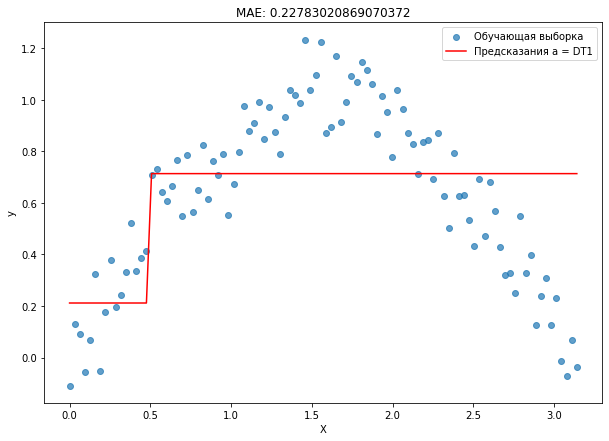

In [20]:
# Инициализация
np.random.seed(123)
N = 100
X = np.linspace(0, 1*np.pi, N).reshape(-1, 1)
y = np.sin(X)[:, 0] + np.random.normal(0, 0.1, size = N)
a = 0

# Обучение решающего дерева глубины 1 и получение предсказаний на обучающей выборке
dt1 = DecisionTreeRegressor(max_depth = 1)
dt1.fit(X, y)
dt1_pred = dt1.predict(X)

# Включение предсказаний первого дерева в композицию (простым суммированием)
a = dt1_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, y_pred_label = 'Предсказания a = DT1', loss = 'mae')

In [21]:
# Вычисление антиградиента 
s1 = -np.sign(a - y)

In [22]:
# TODO: подберите (угадайте) вес так, чтобы уменьшить MAE
w = 0.5

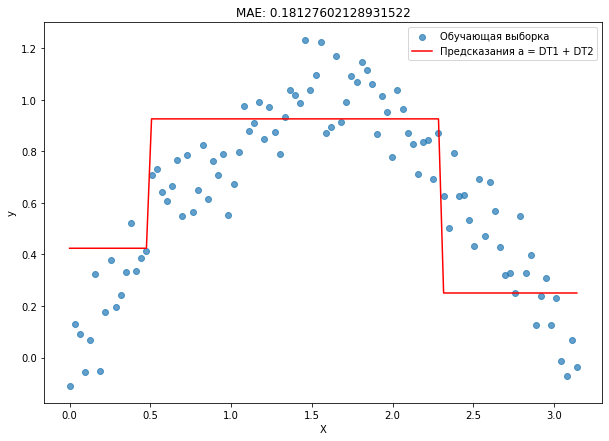

In [23]:
# Обучение второго решающего дерева глубины 1, предсказывающего антиградиент
dt2 = DecisionTreeRegressor(max_depth = 1)
dt2.fit(X, s1)

# Получение предсказаний на обучающей выборке
dt2_pred = dt2.predict(X)

# Включение предсказаний второго дерева в композицию (простым суммированием)
a += w * dt2_pred

# Визуализация выборки и предсказаний
plot_sample_model(X, y, plot_predictions = True, y_pred = a, 
                  y_pred_label = 'Предсказания a = DT1 + DT2', loss = 'mae')

#### 3.2 Переобучение.

Вспомним, что в случае бэггинга увеличение числа базовых моделей не приводит к переобучению. Мы могли бы наблюдать, что вслучайном лесе ошибки на тренировочной и тестовой выборках выходили на плато, начиная с какого-то числа деревьев. Понятно, что бустинг не будет обладать этим свойством *по построению*: при добавлении новых базовых моделей композиция всё точнее будет приближать обучающую выборку, что в конечном итоге (зачастую быстро) может привести к переобучению. Из этого можно сделать вывод, что в случае бустинга ошибка на обучающей выборке в зависимости от числа деревьев является убывающей функцией, а ошибка на тестовой выборке, скорее всего, имеет U-образный вид. Убедимся в этом и сравним поведение ошибок и решающих поверхностей бустинга и случайного леса. 

Здесь и далее будем использовать [реализацию бустинга](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) из `sklearn`, которая представляет собой градиентный бустинг над деревьями.

In [24]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [25]:
# Генерация выборки
np.random.seed(123)
X = np.linspace(0, 1, 300).reshape(-1, 1)

def target(a):
    return a > 0.5

y = target(X) + np.random.normal(size = X.shape) * 0.1
y = y[:, 0]

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

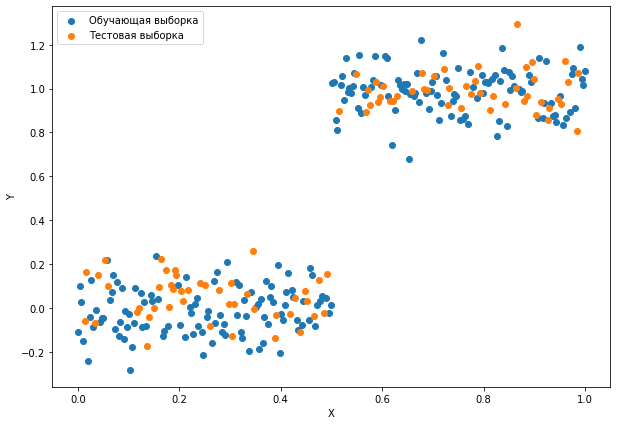

In [27]:
# Визуализация выборки
plt.figure(figsize = (10, 7))
plt.scatter(X_train, y_train, label = 'Обучающая выборка')
plt.scatter(X_test, y_test, label = 'Тестовая выборка')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend();

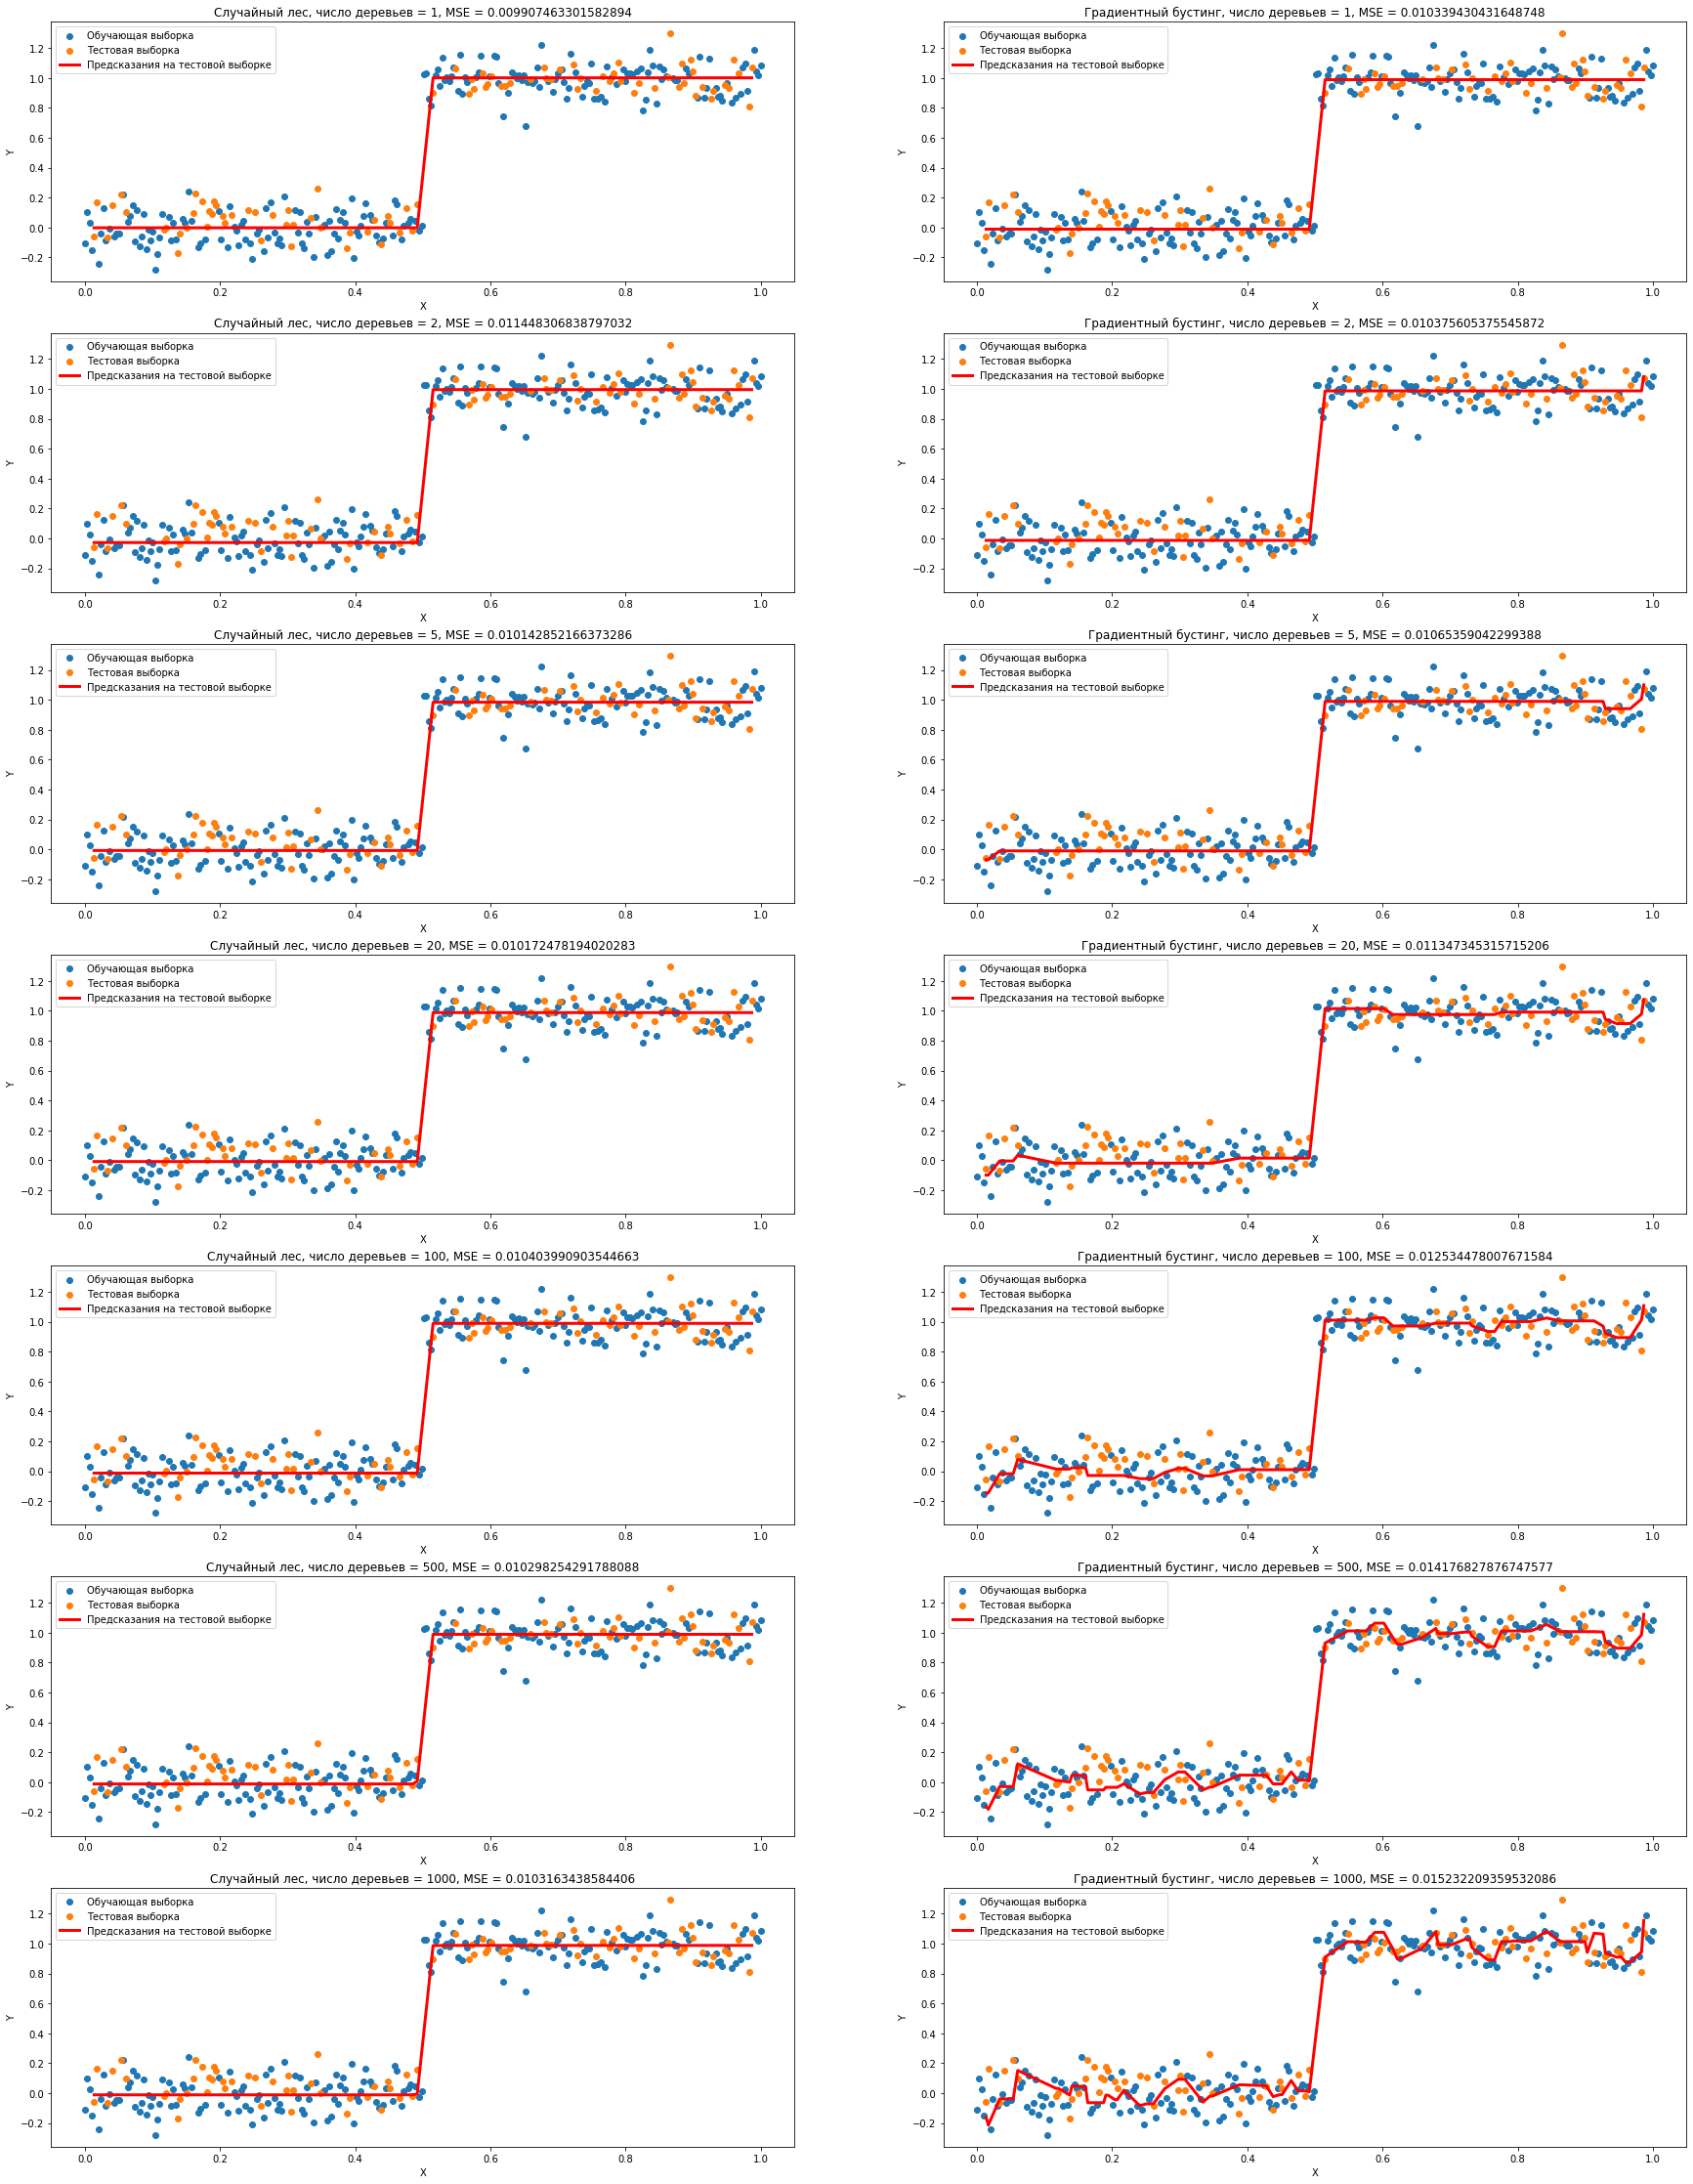

In [28]:
# Визуализация решающих поверхностей
trees = [1, 2, 5, 20, 100, 500, 1000]

fig, ax = plt.subplots(len(trees), 2, figsize = (30, 40))

loss_rf_train = []
loss_gb_train = []
loss_rf_test = []
loss_gb_test = []

for i, ts in enumerate(trees):
    rf = RandomForestRegressor(n_estimators = ts, max_depth = 1)
    gb = GradientBoostingRegressor(n_estimators = ts, max_depth = 1, learning_rate = 1)
    
    rf.fit(X_train, y_train)
    ax[i, 0].scatter(X_train, y_train, label = 'Обучающая выборка')
    ax[i, 0].scatter(X_test, y_test, label = 'Тестовая выборка')
    ax[i, 0].plot(sorted(X_test), rf.predict(sorted(X_test)), lw = 3, c = 'red', label = 'Предсказания на тестовой выборке')
    ax[i, 0].set_xlabel('X')
    ax[i, 0].set_ylabel('Y')
    ax[i, 0].set_title('Случайный лес, число деревьев = ' + str(ts) + ', MSE = ' + str(mean_squared_error(y_test, rf.predict(X_test))))
    ax[i, 0].legend();
    
    loss_rf_train.append(mean_squared_error(y_train, rf.predict(X_train)))
    loss_rf_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    
    gb.fit(X_train, y_train)
    ax[i, 1].scatter(X_train, y_train, label = 'Обучающая выборка')
    ax[i, 1].scatter(X_test, y_test, label = 'Тестовая выборка')
    ax[i, 1].plot(sorted(X_test), gb.predict(sorted(X_test)), lw = 3, c = 'red', label = 'Предсказания на тестовой выборке')
    ax[i, 1].set_xlabel('X')
    ax[i, 1].set_ylabel('Y')
    ax[i, 1].set_title('Градиентный бустинг, число деревьев = ' + str(ts) + ', MSE = ' + str(mean_squared_error(y_test, gb.predict(X_test))))
    ax[i, 1].legend();
    
    loss_gb_train.append(mean_squared_error(y_train, gb.predict(X_train)))
    loss_gb_test.append(mean_squared_error(y_test, gb.predict(X_test)))

Как мы видим, решающая поверхность случайного леса не изменяется (уже со второго дерева), в то время как для бустинга она становится всё более сложной.

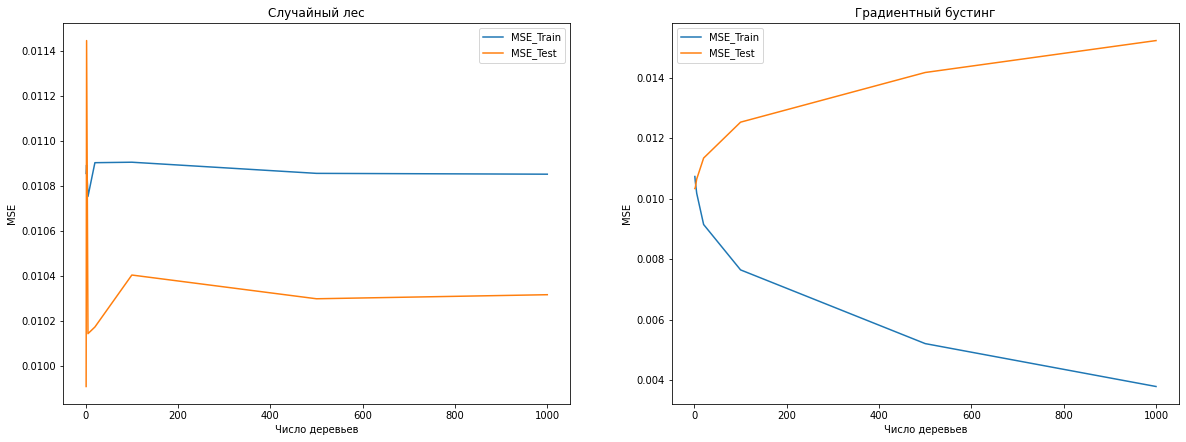

In [29]:
# Визуализация ошибок
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

ax[0].plot(trees, loss_rf_train, label = 'MSE_Train')
ax[0].plot(trees, loss_rf_test, label = 'MSE_Test')
ax[0].set_xlabel('Число деревьев')
ax[0].set_ylabel('MSE')
ax[0].set_title('Случайный лес')
ax[0].legend()

ax[1].plot(trees, loss_gb_train, label = 'MSE_Train')
ax[1].plot(trees, loss_gb_test, label = 'MSE_Test')
ax[1].set_xlabel('Число деревьев')
ax[1].set_ylabel('MSE')
ax[1].set_title('Градиентный бустинг')
ax[1].legend();

В случае бустинга ошибка на тренировочной выборке стабильно убывает, а на тестовой – возрастает, что вероятно говорит об (очень быстром) переобучении. Если же мы аккуратно подберём гиперпараметры для деревьев и длину шага, то сможем добиться типичной U-образной формы функции потерь на тестовой выборке.

В качестве способа регуляризации также может использоваться сокращение шага:

$$
a^{(N)}(X) = a^{(N-1)}(X) + \alpha w_N b^{(N)}(X),
$$

где $\alpha \in (0, 1]$ – темп обучения, или стохастический градиентный бустинг.

**Важный момент:** примеры выше демонстрируют, насколько быстро бустинг может переобучаться, и как в его случае важен подбор гиперпараметров. В связи с этим может сложиться ситуация, что градиентный бустинг с дефолтными параметрами показывает более плохое качество, чем, например, случайный лес с дефолтными параметрами, однако хорошо настроенный градиентный бустинг [обычно превосходит](https://www.quora.com/How-can-the-performance-of-a-Gradient-Boosting-Machine-be-worse-than-Random-Forests) случайный лес по качеству. Важна и конкретная реализация бустинга: например, [здесь](https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956), представлено очень хорошее сравнение различных имплементаций. 

#### 3.3 Пара слов о смещении и дисперсии.

Вспомним, что в случайном лесе в качестве базовых моделей мы брали переобученные деревья, мотивируя это тем, что бэггинг позволит сохранить низкое смещение и при этом уменьшить дисперсию. Бустинг по построению работает проивоположно: композиция обладает более низким, чем базовые модели, смещением, но такой же или большей дисперсией (ещё раз проговорите последовательность построения бустинга, и вы увидите, почему это так). Поэтому в качестве базовых моделей для бустинга обычно используются модели с высоким смещением и низкой дисперсией – как мы знаем, такие модели являются недообученными – например, неглубокие решающие деревья.